In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
from sklearn.impute import KNNImputer

from scipy.stats import shapiro, levene, mannwhitneyu

In [3]:
fb_ads = pd.read_excel('/content/drive/MyDrive/취업준비/MMM/fb_ad/ad_campaign_data_modified.xlsx')

In [4]:
fb_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ad_id        9000 non-null   int64  
 1   Campaign     9000 non-null   object 
 2   Impressions  9000 non-null   int64  
 3   Clicks       9000 non-null   int64  
 4   Spent        9000 non-null   float64
 5   Conversion   9000 non-null   int64  
 6   Sales        9000 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 492.3+ KB


In [5]:
fb_ads.Campaign.value_counts()

before       3000
no_coupon    3000
coupon       3000
Name: Campaign, dtype: int64

## 전처리

In [6]:
fb_ads["Clicks"].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
fb_ads_imputed = pd.DataFrame(imputer.fit_transform(fb_ads.drop(columns=["ad_id", "Campaign"])))

In [7]:
fb_ads.isnull().sum()

ad_id          0
Campaign       0
Impressions    0
Clicks         0
Spent          0
Conversion     0
Sales          0
dtype: int64

In [10]:
# 정규성 검정 결과를 저장할 딕셔너리
normality_test_results = {}

# 변수들에 대해 Shapiro-Wilk 정규성 검정 수행
variables = ['Impressions', 'Clicks', 'Spent', 'Conversion', 'Sales']
for var in variables:
    stat, p = shapiro(fb_ads[var])
    normality_test_results[var] = {'Statistic': stat, 'p-value': p}

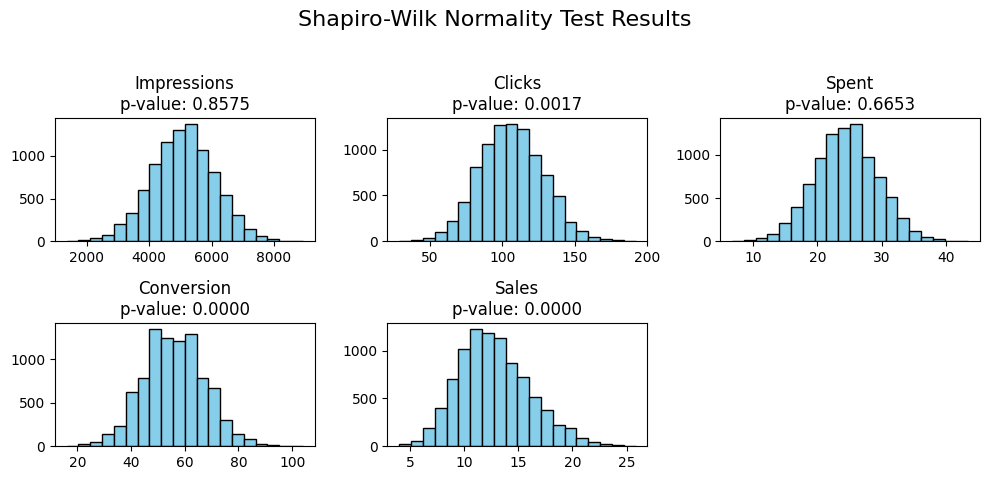

In [11]:
# 정규성 검정 결과 시각화
plt.figure(figsize=(10, 5))
plt.suptitle('Shapiro-Wilk Normality Test Results', fontsize=16)
for i, (var, result) in enumerate(normality_test_results.items()):
    plt.subplot(2, 3, i+1)
    plt.hist(fb_ads[var], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'{var}\np-value: {result["p-value"]:.4f}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [12]:
# 상관분석 수행
correlation_matrix = fb_ads[variables].corr()

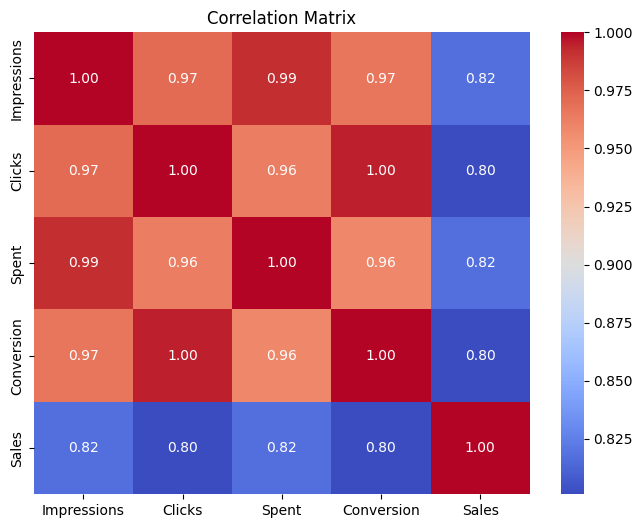

(None,
 {'Impressions': {'Statistic': 0.9998525977134705,
   'p-value': 0.8574503660202026},
  'Clicks': {'Statistic': 0.9993399977684021,
   'p-value': 0.0016822052421048284},
  'Spent': {'Statistic': 0.9998124837875366, 'p-value': 0.6653125286102295},
  'Conversion': {'Statistic': 0.9988191723823547,
   'p-value': 3.640740715127322e-06},
  'Sales': {'Statistic': 0.9874162673950195,
   'p-value': 1.6913824920399807e-27}})

In [13]:
# 상관분석 결과 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show(), normality_test_results

## 광고 지표

### 캠페인 전후 비교

In [14]:
before_promotion = fb_ads[fb_ads['Campaign'] == 'before']
coupon_promotion = fb_ads[fb_ads['Campaign'] == 'coupon']
no_coupon_promotion = fb_ads[fb_ads['Campaign'] == 'no_coupon']

In [15]:
def calculate_metrics(df):
    metrics = {
        'CTR': (df['Clicks'] / df['Impressions']).mean() * 100,
        'Conversion Rate': (df['Conversion'] / df['Clicks']).mean() * 100,
        'ROAS': (df['Sales'] / df['Spent']).mean(),
        'CPM': (df['Spent'] / (df['Impressions'] / 1000)).mean()
    }
    return metrics

In [16]:
# Combining 'coupon' and 'no_coupon' data as 'after_promotion'
after_promotion = pd.concat([coupon_promotion, no_coupon_promotion])

# Calculating metrics for 'after_promotion'
metrics_before = calculate_metrics(before_promotion)
metrics_after = calculate_metrics(after_promotion)

# Preparing a DataFrame to compare 'before' and 'after' metrics
comparison_metrics = pd.DataFrame({'Before Promotion': metrics_before, 'After Promotion': metrics_after})

comparison_metrics

,Before Promotion,After Promotion
CTR,2.077905,2.090134
Conversion Rate,52.496297,52.577092
ROAS,0.459782,0.550741
CPM,4.814010,4.795242


In [17]:
bs = before_promotion.Sales.sum()
af = after_promotion.Sales.sum()
print({'Before Sales': bs, 'After Sales': af})

{'Before Sales': 33408.12, 'After Sales': 81512.91}


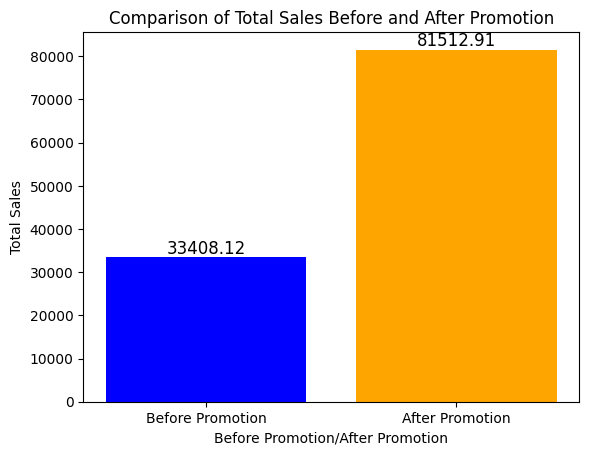

In [18]:
# 막대 그래프 생성
labels = ['Before Promotion', 'After Promotion']
values = [bs, af]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Before Promotion/After Promotion')
plt.ylabel('Total Sales')
plt.title('Comparison of Total Sales Before and After Promotion')

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
# 그래프 표시
plt.show()

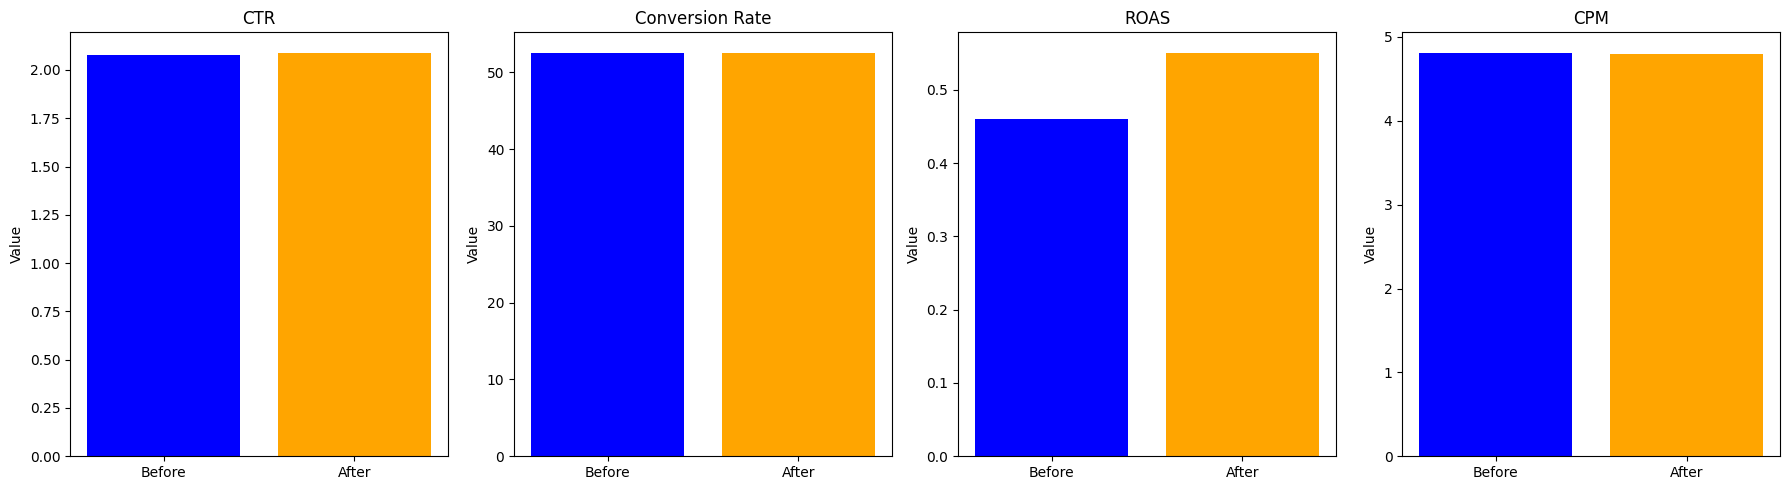

In [19]:
# Re-defining the metrics and their values for plotting
metrics = ['CTR', 'Conversion Rate', 'ROAS', 'CPM']
metrics_before_values = [comparison_metrics.iloc[0,0], comparison_metrics.iloc[1,0], comparison_metrics.iloc[2,0], comparison_metrics.iloc[3,0]]  # Values from the revised calculation
metrics_after_values = [comparison_metrics.iloc[0,1], comparison_metrics.iloc[1,1], comparison_metrics.iloc[2,1], comparison_metrics.iloc[3,1]]  # Values from the revised calculation

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))

# Plotting each metric
for i, metric in enumerate(metrics):
    axes[i].bar('Before', metrics_before_values[i], color='blue')
    axes[i].bar('After', metrics_after_values[i], color='orange')
    axes[i].set_title(metric)
    axes[i].set_ylabel('Value')

# Enhancing layout
plt.tight_layout()

plt.show();

### 쿠폰 발급 유무

In [50]:
cp = coupon_promotion.Sales.mean()
nc = no_coupon_promotion.Sales.mean()
print({'coupon_promotion': cp, 'no_coupon_promotion': nc})

{'coupon_promotion': 15.35918, 'no_coupon_promotion': 11.811789999999998}


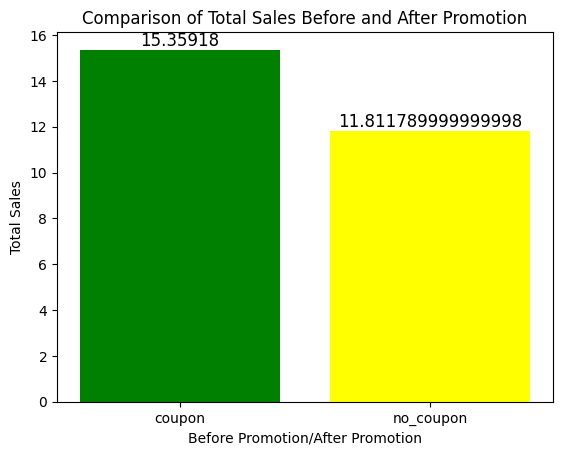

In [51]:
# 막대 그래프 생성
labels = ['coupon', 'no_coupon']
values = [cp, nc]

plt.bar(labels, values, color=['green', 'yellow'])
plt.xlabel('Before Promotion/After Promotion')
plt.ylabel('Total Sales')
plt.title('Comparison of Total Sales Before and After Promotion')

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
# 그래프 표시
plt.show()

In [22]:
# Calculating metrics for 'after_promotion'
metrics_coupon = calculate_metrics(coupon_promotion)
metrics_no = calculate_metrics(no_coupon_promotion)
# Preparing a DataFrame to compare 'before' and 'after' metrics
coupon_metrics = pd.DataFrame({'Coupon': metrics_coupon, 'No Coupon': metrics_no})

coupon_metrics

,Coupon,No Coupon
CTR,2.091910,2.088358
Conversion Rate,52.614579,52.539605
ROAS,0.616273,0.485208
CPM,4.790046,4.800437


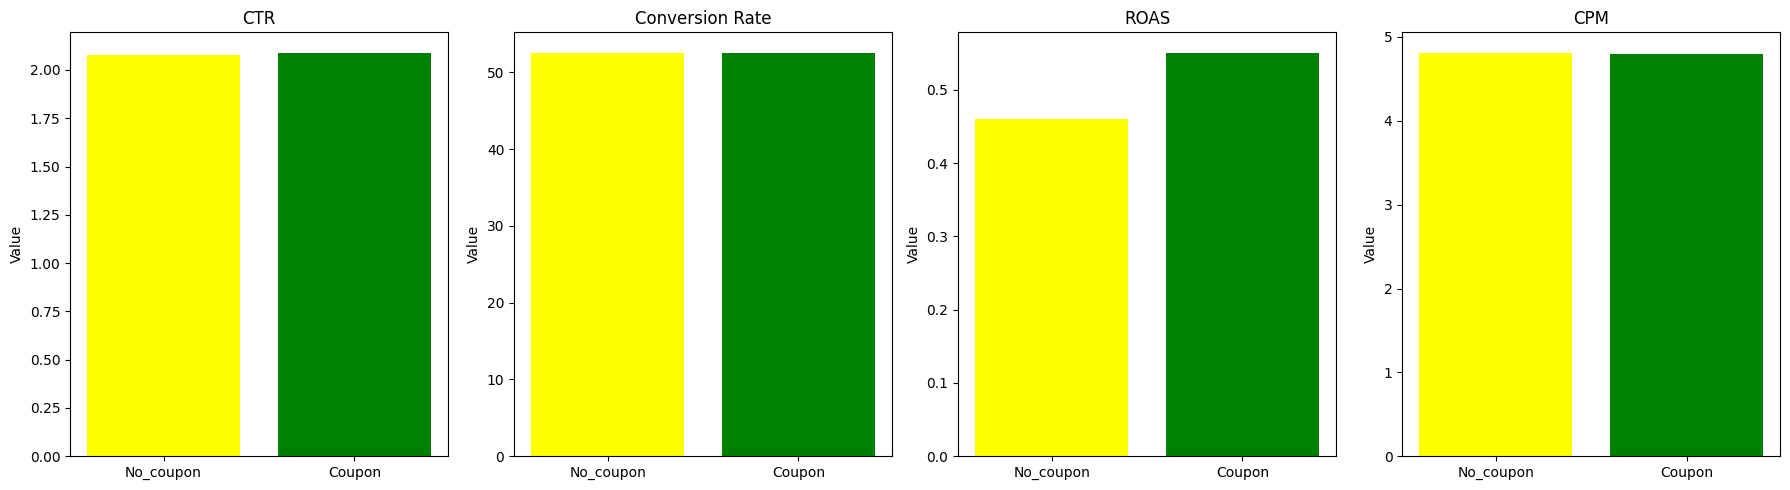

In [54]:
# Re-defining the metrics and their values for plotting
metrics = ['CTR', 'Conversion Rate', 'ROAS', 'CPM']
metrics_before_values = [comparison_metrics.iloc[0,0], comparison_metrics.iloc[1,0], comparison_metrics.iloc[2,0], comparison_metrics.iloc[3,0]]  # Values from the revised calculation
metrics_after_values = [comparison_metrics.iloc[0,1], comparison_metrics.iloc[1,1], comparison_metrics.iloc[2,1], comparison_metrics.iloc[3,1]]  # Values from the revised calculation

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))

# Plotting each metric
for i, metric in enumerate(metrics):
    axes[i].bar('No_coupon', metrics_before_values[i], color='yellow')
    axes[i].bar('Coupon', metrics_after_values[i], color='green')
    axes[i].set_title(metric)
    axes[i].set_ylabel('Value')

# Enhancing layout
plt.tight_layout()

plt.show();

In [24]:
combined_coupon_data = fb_ads[fb_ads['Campaign'] != 'before']

# 'Campaign' 열을 숫자 값으로 변환하여 상관 분석을 위해 'coupon'을 1로, 'no_coupon'을 0으로 할당
combined_coupon_data['Campaign_numeric'] = combined_coupon_data['Campaign'].apply(lambda x: 1 if x == 'coupon' else 0)

<ipython-input-24-7a07b297be86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_coupon_data['Campaign_numeric'] = combined_coupon_data['Campaign'].apply(lambda x: 1 if x == 'coupon' else 0)


In [25]:
variables = ['Campaign_numeric', 'Impressions', 'Clicks', 'Spent', 'Conversion', 'Sales']

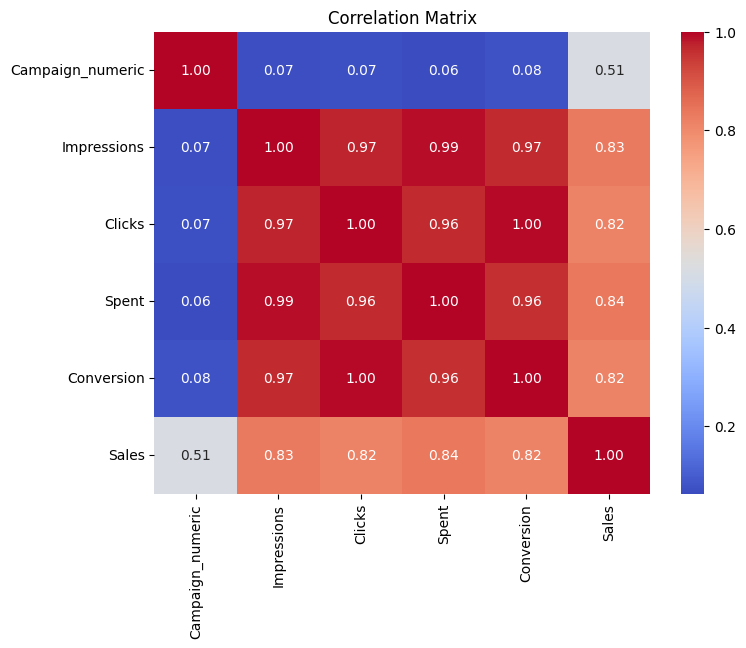

(None,
 {'Impressions': {'Statistic': 0.9998525977134705,
   'p-value': 0.8574503660202026},
  'Clicks': {'Statistic': 0.9993399977684021,
   'p-value': 0.0016822052421048284},
  'Spent': {'Statistic': 0.9998124837875366, 'p-value': 0.6653125286102295},
  'Conversion': {'Statistic': 0.9988191723823547,
   'p-value': 3.640740715127322e-06},
  'Sales': {'Statistic': 0.9874162673950195,
   'p-value': 1.6913824920399807e-27}})

In [26]:
# 상관분석 수행
correlation_matrix = combined_coupon_data[variables].corr()

# 상관분석 결과 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show(), normality_test_results

In [29]:
from scipy.stats import ks_2samp

# KS 검정 수행
ks_stat, p_value = ks_2samp(fb_ads[fb_ads['Campaign'] == 'coupon']['Sales'], fb_ads[fb_ads['Campaign'] == 'no_coupon']['Sales'])

print(f"KS 검정 통계량: {ks_stat}, p-value: {p_value}")

KS 검정 통계량: 0.453, p-value: 9.951351293651563e-278


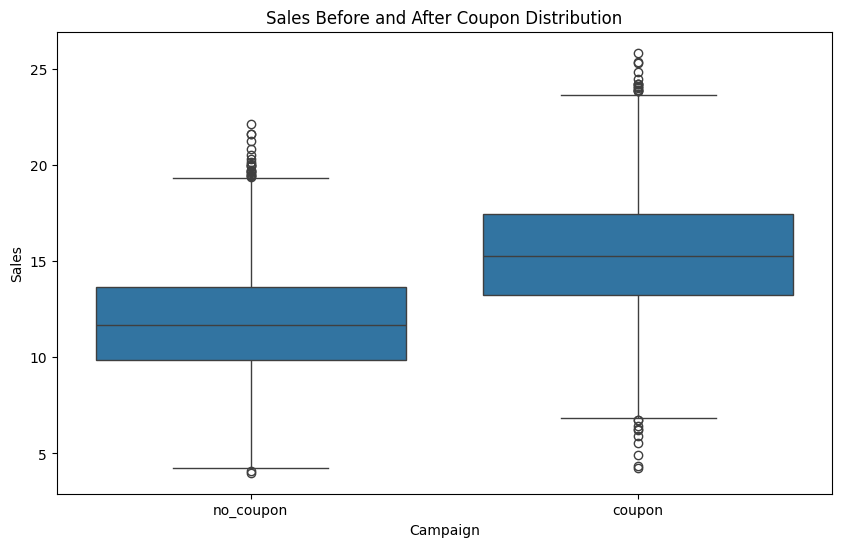

(None, {'Mann-Whitney U Test Statistic': 1777201.0, 'p-value': 0.0})

In [49]:
# Sales가 정규분포를 따르지 않기 때문에 비모수적 방법 채택

# 'before'와 'coupon' 그룹으로 데이터 분리
sales_before = fb_ads[fb_ads['Campaign'] == 'no_coupon']['Sales']
sales_coupon = fb_ads[fb_ads['Campaign'] == 'coupon']['Sales']

# Mann-Whitney U 검정 수행
stat, p = mannwhitneyu(sales_before, sales_coupon)

# 검정 결과 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='Campaign', y='Sales', data=fb_ads[fb_ads['Campaign'].isin(['no_coupon', 'coupon'])])
plt.title('Sales Before and After Coupon Distribution')
plt.xlabel('Campaign')
plt.ylabel('Sales')

plt.show(), {'Mann-Whitney U Test Statistic': stat, 'p-value': p}